
<div class="usecase-title">UC00198_Waste_Management_And_Health_Risks</div>
<div class="usecase-authors">Author: Deepthi Reddy Thatipally</div>

<div class="usecase-level-skill">
  <div class="usecase-level">Level: Intermediate</div>
  <div class="usecase-skill">Skills: Python, Data Visualization</div>
</div>

<div class="usecase-duration">Duration: {90} minutes</div>
"""

<div class="usecase-scenario">
  <h2>Scenario</h2>

<p>The City of Melbourne generates large amounts of waste every month. This waste is collected from different zones and managed through public services. However, when waste collection is delayed or poorly managed, it can lead to problems like bad smells, pests, pollution, and even health issues for people living nearby. As a data analyst, I want to explore whether there is a connection between the amount of waste collected, the public complaints about waste issues, and the health and wellbeing of residents. I will use data from the city’s open data portal to investigate if some zones are more affected than others and whether better waste management could improve community wellbeing.</p>

<h2>What this Use Case will teach you</h2>
  <ul>By working on this use case, you will learn:
    <li>import, clean, and merge multiple real-world datasets from an API</li>
    <li>to use location-based and time-based data to uncover patterns</li>
    <li>to link operational data (waste collection) with social data (health and complaints)</li>
    <li>to use basic data analysis and visualization techniques to support decision-making</li>
    <li>Ito identify areas that may need improved services or health interventions</li>
  </ul>
  
<h2>Background/ Introduction</h2>
<p>Waste management is a key part of keeping cities clean, healthy, and liveable. Poorly managed waste can lead to pollution, spread of disease, and lower quality of life. In Melbourne, different zones are responsible for collecting and managing waste. At the same time, the city collects feedback from residents through customer service complaints and regularly surveys them about their wellbeing.</p>

<ul>This project aims to connect the dots between:
    <li>How much waste is being collected,</li>
    <li>Where that waste is coming from,</li>
    <li>What residents are saying about waste issues,</li>
    <li>And how people are feeling in terms of health and wellbeing.</li>
  </ul>
</div>
"""

display(HTML(html_content))


In [5]:
import requests
import pandas as pd
from io import StringIO

def API_upload(dataset_id):
    core_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    file_format = 'csv'
    
    web_url = f'{core_url}{dataset_id}/exports/{file_format}'
    
    params = {
        'select': '*',
        'timezone': 'UTC',
        'lang': 'en',
        'limit': '-1'
    }
    
    response = requests.get(web_url, params=params)
    
    if response.status_code == 200:
        csv_content = response.content.decode('utf-8')
        try:
            df_dataset = pd.read_csv(StringIO(csv_content), delimiter=';')
        except Exception:
            print("Semicolon delimiter failed, trying comma delimiter.")
            df_dataset = pd.read_csv(StringIO(csv_content))
        
        print(f"\nDataset: {dataset_id}\n")
        print(df_dataset.head())
        print(f"\nTotal records: {len(df_dataset)}")
        return df_dataset
    else:
        print(f"Error fetching data from {web_url}: {response.status_code}")
        return None

# Load each dataset
df_social = API_upload('social-indicators-for-city-of-melbourne-residents-2023')
df_waste = API_upload('waste-collected-per-month')
df_zones = API_upload('garbage-collection-zones')
df_complaints = API_upload('customer-service-requests-with-resolution-time')


Dataset: social-indicators-for-city-of-melbourne-residents-2023

  indicator                    type              topic  \
0        18                   Other             Health   
1        18                   Other             Health   
2        19                   Other             Health   
3         1  Council Plan Indicator  Physical activity   
4         1  Council Plan Indicator  Physical activity   

                                 description  \
0                          Smoking behaviour   
1                          Smoking behaviour   
2                           Vaping behaviour   
3  Participate in adequate physical activity   
4  Participate in adequate physical activity   

                                            response  \
0     Reported as smoke daliy or smoke occassionally   
1     Reported as smoke daliy or smoke occassionally   
2       Reported as vape daliy or vape occassionally   
3  Yes, 30 minutes or more on 4 or more days per ...   
4  Yes, 30 minut

This code connects to the City of Melbourne's open data website and downloads all the required datasets using its API. It checks for different delimiters to make sure the data loads correctly into a DataFrame and prints the first few rows for a quick check.

In [23]:
# Clean column names
df_social.columns = df_social.columns.str.strip().str.lower().str.replace(' ', '_')

# Drop rows with missing key values
df_social.dropna(subset=['indicator', 'result', 'respondent_group'], inplace=True)

# Keep only 'City of Melbourne' for city-wide analysis (optional)
df_social_filtered = df_social[df_social['respondent_group'].str.contains('Melbourne', case=False)].copy()

# Convert result column to numeric
df_social_filtered['result'] = pd.to_numeric(df_social_filtered['result'], errors='coerce')

# Final preview
print(df_social_filtered[['indicator', 'topic', 'description', 'respondent_group', 'result']].head())


   indicator              topic  \
1         18             Health   
3          1  Physical activity   
4          1  Physical activity   
12        2b  Physical activity   
15        6c      Food security   

                                          description  \
1                                   Smoking behaviour   
3           Participate in adequate physical activity   
4           Participate in adequate physical activity   
12  Participate in sports and exercise activities ...   
15                                    Ran out of food   

                                   respondent_group  result  
1                                 City of Melbourne    14.9  
3                                    Melbourne 3000    45.7  
4   South Yarra 3141 / Melbourne/St Kilda Road 3004    61.9  
12                                City of Melbourne    55.5  
15  South Yarra 3141 / Melbourne/St Kilda Road 3004    15.5  


This code cleans the social indicators dataset so it is easy to use. It standardises column names, removes incomplete rows, filters to city-wide responses using the respondant groups, converts the result column to numbers, and prints the first few rows to check if the changes has been made correctly.

In [11]:
# Clean column names
df_waste.columns = df_waste.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert 'date' to datetime
df_waste['date'] = pd.to_datetime(df_waste['date'], errors='coerce')

# Convert all numeric columns (except 'date' and 'month')
for col in df_waste.columns:
    if col not in ['date', 'month']:
        df_waste[col] = pd.to_numeric(df_waste[col], errors='coerce')

# Drop rows with missing date
df_waste = df_waste.dropna(subset=['date'])

# Preview
print(df_waste[['date', 'residential', 'public_litter_bins', 'dumped_rubbish']].head())


        date  residential  public_litter_bins  dumped_rubbish
0 2013-03-01      1669.94              382.81          126.38
1 2018-01-01      2558.41              236.52          153.20
2 2011-11-01      1716.64              371.76          155.18
3 2015-06-01      1896.00              350.14          180.28
4 2015-12-01      2206.70              336.76          190.21


This code standardises the waste dataset, it fixes the column names, parses dates, changes the other columns to numeric, removes rows with missing dates, and the first five rows has been dsiplayed as the result.

In [17]:
print(df_zones.columns.tolist())


['geo_point_2d', 'geo_shape', 'desc', 'name', 'rec_ok', 'rec_weeks', 'rub_start', 'rub_ok', 'rub_day', 'info_url', 'rub_notok', 'rec_url', 'rec_name', 'rec_notok', 'rub_name', 'rec_day', 'rub_weeks', 'rec_start', 'rub_url', 'missed_ph']


this code prints all column names in the garbage collection zones dataset.

In [21]:
# Clean column names
df_zones.columns = df_zones.columns.str.strip().str.lower().str.replace(' ', '_')

# Drop empty rows
df_zones.dropna(how='all', inplace=True)

# Keep only existing relevant columns
df_zones_cleaned = df_zones[['geo_point_2d', 'name', 'rub_day', 'rec_day', 'geo_shape']].copy()

# Rename for clarity
df_zones_cleaned.rename(columns={
    'name': 'collection_day',
    'rub_day': 'rubbish_day',
    'rec_day': 'recycling_day',
    'geo_shape': 'zone_shape'
}, inplace=True)

# Preview cleaned zones
print(df_zones_cleaned.head())


                             geo_point_2d collection_day rubbish_day  \
0    -37.82597212079299, 144.946122910589        Tuesday     Tuesday   
1  -37.78888528182715, 144.94807224053946         Monday      Monday   
2  -37.81350068415623, 144.98033118663488         Friday      Friday   
3  -37.80199461843715, 144.92363364191561       Thursday    Thursday   
4   -37.79143593526807, 144.9329101787968        Tuesday     Tuesday   

  recycling_day                                         zone_shape  
0       Tuesday  {"coordinates": [[[[144.972962214293, -37.8197...  
1        Monday  {"coordinates": [[[[144.960219332351, -37.7780...  
2        Friday  {"coordinates": [[[[144.991297895403, -37.8098...  
3      Thursday  {"coordinates": [[[[144.921156607569, -37.7872...  
4       Tuesday  {"coordinates": [[[[144.9348836245, -37.794983...  


This code cleans the garbage collection zones dataset, it removes the empty rows, keeps only useful relevant columns which are useful for the analysis, and renames them to more meaningful names. The first five rows of the cleaned dataset has been displayed.

In [15]:
# Clean column names
df_complaints.columns = df_complaints.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert dates
df_complaints['date_received'] = pd.to_datetime(df_complaints['date_received'], errors='coerce')
df_complaints['date_completed'] = pd.to_datetime(df_complaints['date_completed'], errors='coerce')

# Filter: Only Waste-related categories
df_complaints = df_complaints[
    df_complaints['category'].str.contains('waste|rubbish|litter|garbage', case=False, na=False)
]

# Drop missing values
df_complaints.dropna(subset=['suburb', 'category', 'date_received'], inplace=True)

# Preview
print(df_complaints[['date_received', 'suburb', 'category', 'service_desc']].head())


  date_received           suburb                           category  \
2    2014-12-16        Southbank  Waste, Street Cleaning and Litter   
3    2015-01-05        Docklands  Waste, Street Cleaning and Litter   
5    2015-04-28   East Melbourne  Waste, Street Cleaning and Litter   
7    2015-05-04  North Melbourne  Waste, Street Cleaning and Litter   
9    2015-05-08      South Yarra  Waste, Street Cleaning and Litter   

                service_desc  
2          Public Litter Bin  
3               Damaged Bins  
5                Missing Bin  
7  Waste collection services  
9          Public Litter Bin  


This standardises and filters the complaints dataset from customer service requests. It cleans headers, converts date, keeps only categories which are relevant to the waste category, removes rows missing essential information, and prints the first five rows to check the data.

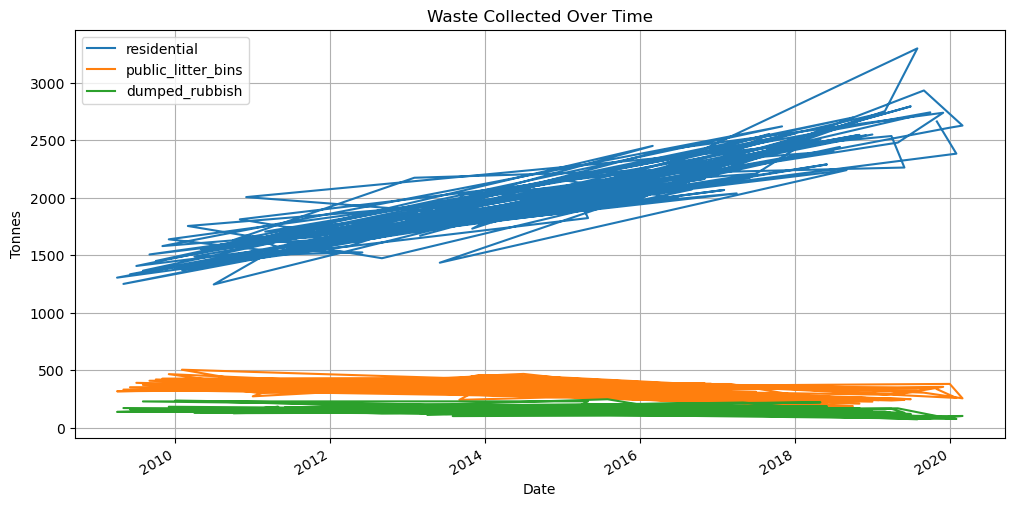

In [25]:
import matplotlib.pyplot as plt

df_waste.set_index('date')[['residential', 'public_litter_bins', 'dumped_rubbish']].plot(figsize=(12,6))
plt.title('Waste Collected Over Time')
plt.ylabel('Tonnes')
plt.xlabel('Date')
plt.grid(True)
plt.show()


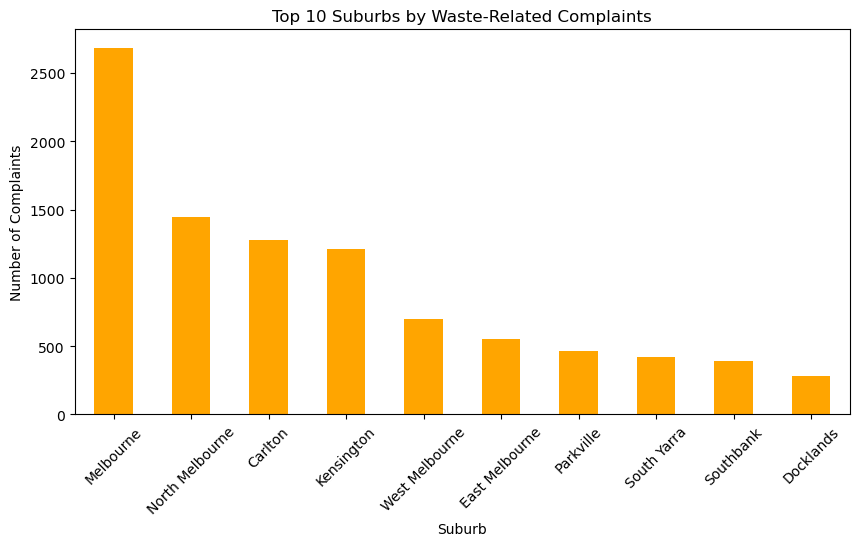

In [27]:
top_suburbs = df_complaints['suburb'].value_counts().head(10)

top_suburbs.plot(kind='bar', color='orange', figsize=(10,5))
plt.title('Top 10 Suburbs by Waste-Related Complaints')
plt.xlabel('Suburb')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.show()


This code counts the complaints per suburb, and the top 10 suburbs with highest complaints are shown in a bar chart. It helps you see where most waste-related issues are being reported.

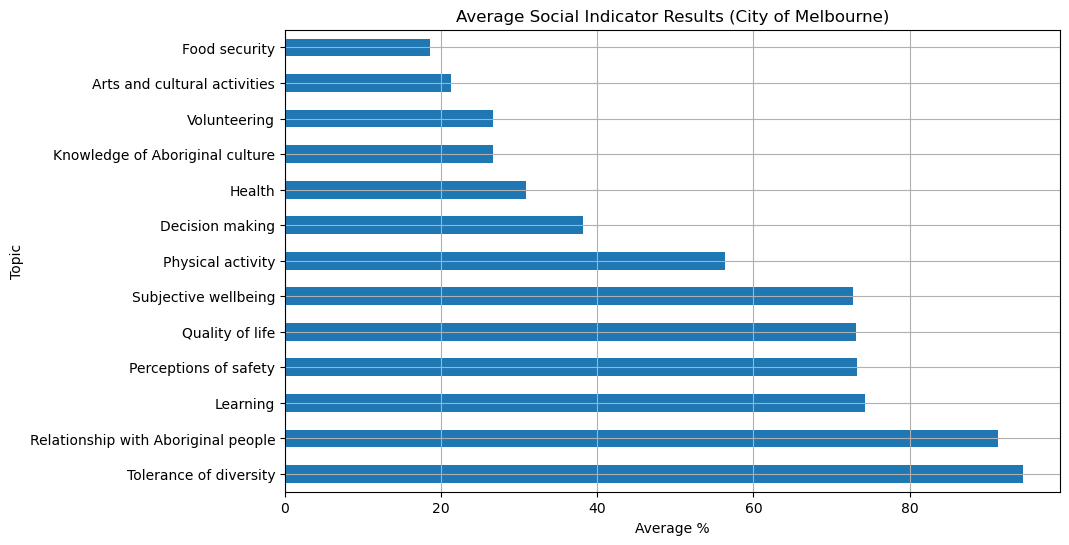

In [29]:
# Group and get average result per topic
health_summary = df_social_filtered.groupby('topic')['result'].mean().sort_values(ascending=False)

health_summary.plot(kind='barh', figsize=(10,6))
plt.title('Average Social Indicator Results (City of Melbourne)')
plt.xlabel('Average %')
plt.ylabel('Topic')
plt.grid(True)
plt.show()


This summarises the social indicators by topic. It calculates the avegare score for each topic, sorths them, and the result is showin as a horizontal bar chart which helps easily compare the topics.

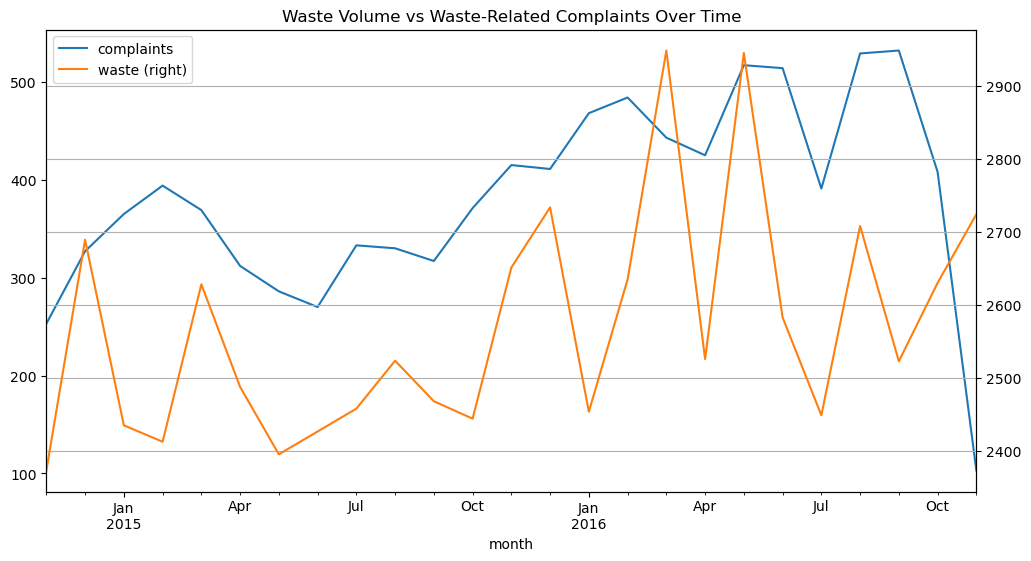

In [31]:
# Complaints per month
df_complaints['month'] = df_complaints['date_received'].dt.to_period('M').dt.to_timestamp()
monthly_complaints = df_complaints.groupby('month').size()

# Waste per month (total of selected categories)
df_waste['month'] = df_waste['date'].dt.to_period('M').dt.to_timestamp()
df_waste['total_waste'] = df_waste[['residential', 'dumped_rubbish', 'public_litter_bins']].sum(axis=1)
monthly_waste = df_waste.groupby('month')['total_waste'].sum()

# Combine and plot
combined = pd.DataFrame({'complaints': monthly_complaints, 'waste': monthly_waste}).dropna()

combined.plot(figsize=(12,6), secondary_y='waste')
plt.title('Waste Volume vs Waste-Related Complaints Over Time')
plt.xlabel('Month')
plt.grid(True)
plt.show()


This creates a monthly counts for complaints and monthly totals for waste, combines them on a monthly basis, and plots them together. This line chart helps us to compare the trends even tho the units are different with the help of secondary y-axis.